# nn

> Lightweight neural network implementation on top of Value autograd framework

In [ ]:
#| default_exp nn

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from minion.core import Value
import random
from typing import List

In [ ]:
#| hide
from minion.utils import draw_dot
from IPython.display import SVG, display

In [ ]:
%matplotlib inline

In [ ]:
#| export 

class Module(object):
    # def __init__(self) -> None:
    #     pass

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

    def num_params(self):
        return len(self.parameters())
    
    def parameters(self):
        pass
    # def __repr__(self) -> str:
    #     return "This is a minion module"

In [ ]:
Module()

<__main__.Module>

## Neuron Implementation

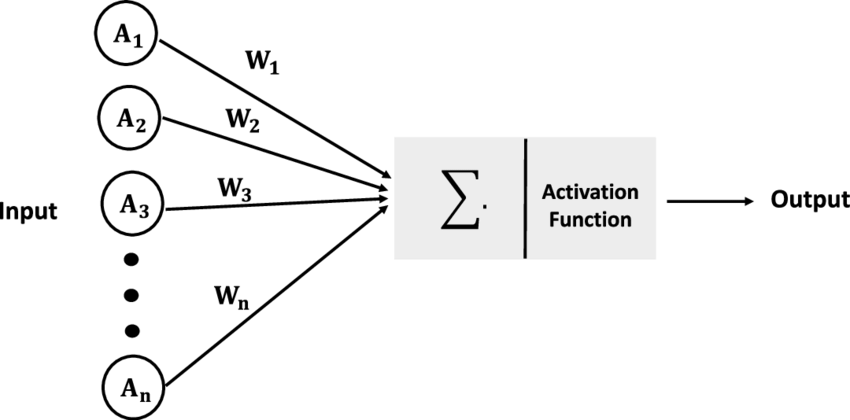

In [ ]:
#| export
class Neuron(Module):
    def __init__(self, nin) -> None:
        super().__init__()
        # self.weights = [Value(random.random()) for _ in range(nin)]
        # self.bias = Value(random.random())
        self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, xs) -> Value:
        out = sum((w*x for w,x in zip(self.weights, xs)), self.bias)
        return out.tanh()
    
    def parameters(self):
        return self.weights + [self.bias]


In [ ]:
xs = [1, 2, 3, 4]

n = Neuron(len(xs))
n(xs)


Value(data=-0.9999816874198546)

In [ ]:
n.parameters()

[Value(data=0.2996475661487965),
 Value(data=-0.6267630844346634),
 Value(data=-0.9246264014404468),
 Value(data=-0.4674702685842562),
 Value(data=-0.20289127806601925)]

## Layer Implementation

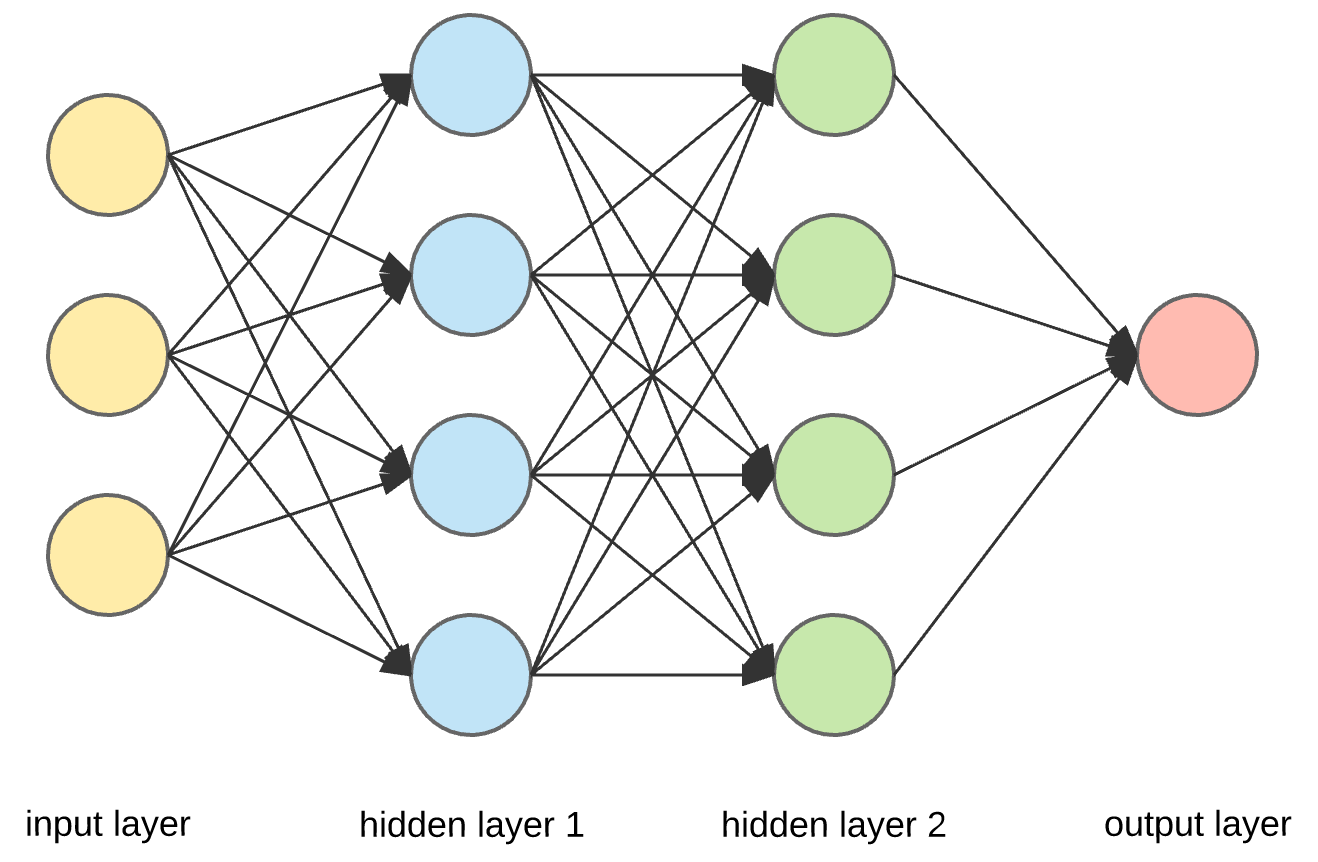

In [ ]:
#| export
class Layer(Module):

    def __init__(self, nin, nout) -> None:
        super().__init__()
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, xs) -> List[Value]:
        ys = [neuron(xs) for neuron in self.neurons]
        return ys
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [ ]:
xs = [1, 2, 3, 4]

l = Layer(len(xs), 3)
l(xs)

[Value(data=0.7048653358992089),
 Value(data=0.7624645201923977),
 Value(data=-0.5361441307353372)]

In [ ]:
# len(l.parameters()), l.parameters()
l.num_params(), l.parameters()

(15,
 [Value(data=-0.735292639179753),
  Value(data=-0.46621362338222494),
  Value(data=0.31216478566074635),
  Value(data=0.32439718817347507),
  Value(data=0.31054160829965216),
  Value(data=0.5389804840056651),
  Value(data=0.49574071178176227),
  Value(data=-0.52360851024096),
  Value(data=0.26985245436198113),
  Value(data=-0.03697049273643227),
  Value(data=-0.20940467223829673),
  Value(data=0.6855711092076937),
  Value(data=-0.2123166216168204),
  Value(data=-0.1822824061529016),
  Value(data=-0.39438649023126526)])

## Multilayer Perceptron implementation

In [ ]:
#| export

class MLP(Module):
    def __init__(self, nin, nouts) -> None:
        super().__init__()
        self.layers = [Layer(lin, lout) for lin,lout in zip([nin]+nouts[:-1], nouts)]

    def __call__(self, xs):
        x = xs
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) ==1 else x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
nin = len(xs)
nouts = [3,4,4,1]
# for lin,lout in zip([nin]+nouts[:-1], nouts):
#     print(lin, lout)

mlp = MLP(nin, nouts)
mlp(xs), mlp.num_params()

(Value(data=-0.07189402118195996), 56)

In [ ]:
# for lin,lout in zip([nin]+nouts[:-1], nouts):
#     print(lin, lout)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 0.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
nin = len(xs[0])
nouts = [4,4,1]
mlp = MLP(nin, nouts)
y_preds = [mlp(x) for x in xs]; y_preds

[Value(data=-0.9092726328584118),
 Value(data=-0.8971560386646303),
 Value(data=-0.8972030311657623),
 Value(data=-0.918073509910156)]

In [ ]:
loss = sum((y-y_pred)**2 for y, y_pred in zip(ys, y_preds))
loss

Value(data=7.345472073185816)

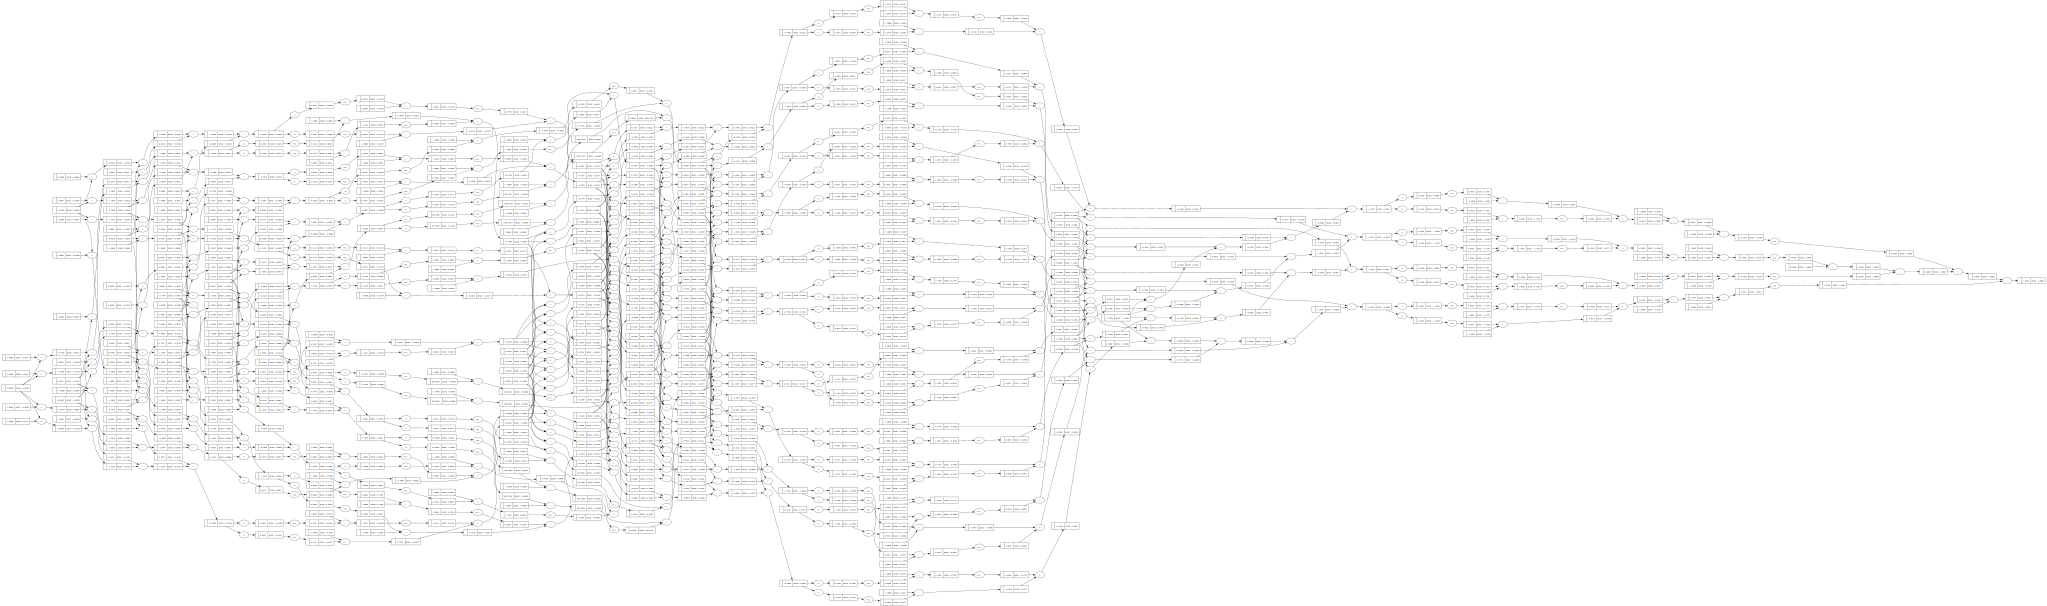

In [ ]:
loss.backward()
draw_dot(loss)

In [ ]:
step_size = 0.01
# for p in mlp.parameters():
p = mlp.parameters()[0]
p.grad, p.data
    

(0.0003160544492504312, -0.20452920628415744)

In [ ]:
mlp.layers[0].neurons[0].weights[0].grad, mlp.layers[0].neurons[0].weights[0]

(0.0003160544492504312, Value(data=-0.20452920628415744))

In [ ]:
step_size = 0.1
for k in range(200):
    y_preds = [mlp(x) for x in xs]; y_preds
    loss = sum((y-y_pred)**2 for y, y_pred in zip(ys, y_preds))
    mlp.zero_grad()
    loss.backward()
    for p in mlp.parameters():
        p.data -= step_size*p.grad
    print(k, loss.data)

0 0.0013144825642295425
1 0.0013065773994759486
2 0.0012987650979127516
3 0.0012910440439571425
4 0.0012834126591459902
5 0.0012758694010784333
6 0.0012684127623942536
7 0.001261041269786802
8 0.0012537534830490676
9 0.0012465479941515204
10 0.0012394234263506476
11 0.0012323784333267843
12 0.0012254116983503624
13 0.0012185219334753645
14 0.001211707878758976
15 0.0012049683015063265
16 0.0011983019955397005
17 0.001191707780490962
18 0.0011851845011165507
19 0.001178731026634071
20 0.001172346250079836
21 0.0011660290876864667
22 0.0011597784782798942
23 0.0011535933826950608
24 0.0011474727832095593
25 0.0011414156829947766
26 0.0011354211055836336
27 0.0011294880943545928
28 0.0011236157120311791
29 0.0011178030401966382
30 0.0011120491788230093
31 0.001106353245814232
32 0.0011007143765629024
33 0.001095131723519913
34 0.0010896044557768638
35 0.0010841317586605796
36 0.0010787128333394369
37 0.0010733468964410527
38 0.001068033179681
39 0.0010627709295021642
40 0.0010575594067242

In [ ]:
y_preds

[Value(data=0.9894351129108765),
 Value(data=-0.998879606224376),
 Value(data=-0.9873883237450028),
 Value(data=0.982124086433846)]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()